In [1]:
"""Backend supported: pytorch, paddle, jax

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""

import deepxde as dde
import numpy as np
import time
import os
import argparse
import jax
import jax.numpy as jnp
from jaxopt import GaussNewton
from scipy.interpolate import RegularGridInterpolator

Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [2]:
n_iter = 1000
log_every = 100
available_time = 0
log_output_fields = {0: 'Ux', 1: 'Uy', 2: 'Sxx', 3: 'Syy', 4: 'Sxy'}
net_type = 'spinn'
bc_type = 'hard'
mlp = 'mlp'
n_DIC = 200
noise_magnitude = 0
lr = 0.001
u_0 = 1e-6
loss_weights = [1,1,1,1,1,1,1e2,1e2,1e2]

save_model = True

In [3]:
#%%
if net_type == "spinn":
    dde.config.set_default_autodiff("forward")

x_max = 2.0
y_max = 2.0
R = 0.5
E = 210e3  # Young's modulus
nu = 0.3  # Poisson's ratio

lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame's first parameter
mu = E / (2 * (1 + nu))  # Lame's second parameter

# Load
pstress = 1.0


sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack

# Load geometry mapping
nx=100
ny=100
dir_path = r"."
Xp = np.loadtxt(os.path.join(dir_path, f"plate_hole_quarter_{nx}x{ny}.txt"))

# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def coordMap(x, X_map = X_map_points, Y_map = Y_map_points, x_max = x_max, y_max=y_max, padding=1e-6):
    x_pos = x[0] / x_max * (X_map.shape[0]-1) * (1-2*padding) + padding
    y_pos = x[1] / y_max * (Y_map.shape[1]-1) * (1-2*padding) + padding
    xm = jax.scipy.ndimage.map_coordinates(X_map,
           [x_pos, y_pos], order=1, mode='nearest')
    ym = jax.scipy.ndimage.map_coordinates(Y_map,
           [x_pos, y_pos], order=1, mode='nearest')
    return jnp.stack([xm, ym])

def F(x, phys_xy, X_map, Y_map, x_max, y_max, padding):
    return coordMap(x, X_map, Y_map, x_max, y_max, padding) - phys_xy

@jax.jit
def inv_coord_map(phys_xy, X_map = X_map_points, Y_map = Y_map_points, x_max = x_max, y_max=y_max, padding=1e-6):
    # initial guess at the center
    init_guess = jnp.array([0.5 * x_max, 0.5 * y_max])
    solver = GaussNewton(residual_fun=F,
                            tol=1e-6,
                            maxiter=25,
                            implicit_diff=True)
    sol = solver.run(
        init_params=init_guess,
        phys_xy=phys_xy,
        X_map=X_map,
        Y_map=Y_map,
        x_max=x_max,
        y_max=y_max,
        padding=padding
    ).params
    return sol


def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    J_inv = jnp.linalg.inv(J)
    return tens @ J_inv

def calcNormal(x):
    n = jnp.array([-1, 0])
    n_mapped = tensMap(n, x)
    return n_mapped/jnp.linalg.norm(n_mapped)
    

# Load solution
n_mesh_x = 100
n_mesh_y = 100

data = np.loadtxt(os.path.join(dir_path, f"fem_solution_{n_mesh_x}x{n_mesh_y}.dat"))
X_val = data[:, :2]
u_val = data[:, 2:4]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

# Interpolate solution
x_grid = np.linspace(0, x_max, n_mesh_x)
y_grid = np.linspace(0, y_max, n_mesh_y)

interpolators = []
for i in range(solution_val.shape[1]):
    interp = RegularGridInterpolator((x_grid, y_grid), solution_val[:, i].reshape(n_mesh_y, n_mesh_x).T)
    interpolators.append(interp)

def solution_fn(x):
    if net_type == "spinn" and isinstance(x, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(x[0].squeeze()), 
            jnp.atleast_1d(x[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    # x = jax.vmap(coordMap)(x)
    return np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

# geom = dde.geometry.Rectangle([0, 0], [x_max, y_max])

n_pde = 100
x_train = np.linspace(0, x_max, n_pde).reshape(-1, 1)
y_train = np.linspace(0, y_max, n_pde).reshape(-1, 1)
geom = dde.geometry.ListPointCloud([x_train, y_train])


def HardBC(x, f):
    if net_type == "spinn" and isinstance(x, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(x[0].squeeze()), 
            jnp.atleast_1d(x[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    x_mapped = jax.vmap(coordMap)(x)

    Ux = f[:, 0] * x_mapped[:, 0] / x_max * (y_max - x[:, 1]) / x_max * u_0
    Uy = f[:, 1] * x[:, 1] / x_max *u_0

    Sxx = f[:, 2] * (x_max - x[:, 0]) / x_max
    Syy = f[:, 3] * (y_max - x[:, 1]) / x_max + pstress
    Sxy = f[:, 4] * x_mapped[:, 0] / x_max * x[:, 1] / x_max * (x_max - x[:, 0]) / x_max

    return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)


def pde(x, f):
    # x_mesh = jnp.meshgrid(x[:,0].ravel(), x[:,0].ravel(), indexing='ij')
    if net_type == "spinn" and isinstance(x, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(x[0].squeeze()), 
            jnp.atleast_1d(x[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    # x_phys = jax.vmap(coordMap)(x)

    J_nn = jax.vmap(jax.jacfwd(f[1]))(x)
    J_comp2phys = jax.vmap(jax.jacfwd(coordMap))(x)
    J_phys2comp = jnp.linalg.inv(J_comp2phys)

    J = jnp.einsum("ijk,ikl->ijl", J_nn, J_phys2comp)

    E_xx = J[:, 0:1, 0:1]
    E_yy = J[:, 1:2, 1:2]
    E_xy = 0.5 * (J[:, 0:1, 1:2] + J[:, 1:2, 0:1])
    # E_xx = dde.grad.jacobian(f, x, i=0, j=0)[0] 
    # E_yy = dde.grad.jacobian(f, x, i=1, j=1)[0]
    # E_xy = 0.5 * (dde.grad.jacobian(f, x, i=0, j=1)[0] + dde.grad.jacobian(f, x, i=1, j=0)[0])

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = J[:, 2:3, 0:1]
    Syy_y = J[:, 3:4, 1:2]
    Sxy_x = J[:, 4:5, 0:1]
    Sxy_y = J[:, 4:5, 1:2]

    # Sxx_x = dde.grad.jacobian(f, x, i=2, j=0)[0]
    # Syy_y = dde.grad.jacobian(f, x, i=3, j=1)[0]
    # Sxy_x = dde.grad.jacobian(f, x, i=4, j=0)[0]
    # Sxy_y = dde.grad.jacobian(f, x, i=4, j=1)[0]

    momentum_x = Sxx_x + Sxy_y 
    momentum_y = Sxy_x + Syy_y 

    # if dde.backend.backend_name == "jax":
    #     f = f[0]  # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[0][:, 2:3]
    stress_y = S_yy - f[0][:, 3:4]
    stress_xy = S_xy - f[0][:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

# Integral stress BC
n_integral = 100
x_integral = np.linspace(0, x_max, n_integral).reshape(-1, 1)
y_integral = np.linspace(0, y_max, n_integral).reshape(-1, 1)
integral_points = [x_integral, y_integral]

def integral_stress(inputs, outputs, X):
    if net_type == "spinn" and isinstance(inputs, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(inputs[0].squeeze()), 
            jnp.atleast_1d(inputs[1].squeeze()), 
            indexing="ij"
        )]
        x = stack(x_mesh, axis=-1)
    x_mesh = jax.vmap(coordMap)(x)[:,0].reshape((inputs[0].shape[0], inputs[0].shape[0]))

    Syy = outputs[0][:, 3:4].reshape(x_mesh.shape)
    return jnp.trapezoid(Syy, x_mesh, axis=0)

Integral_BC = dde.PointSetOperatorBC(integral_points, pstress*x_max, integral_stress)

# Free surface BC
n_free = 400
y_free = jnp.linspace(0, x_max, n_free)
X_free = jnp.stack((jnp.zeros(n_free), y_free), axis=1)
sharp_corner_tol = 0.1

mask = (jax.vmap(coordMap)(X_free)[:, 1] < R-sharp_corner_tol) & (sharp_corner_tol < jax.vmap(coordMap)(X_free)[:, 1])
X_free = X_free[mask] #keep bottom left corner: 99 points

X_list = [jnp.array([0]).reshape(-1, 1), X_free[:, 1].reshape(-1, 1)]

def free_surface_balance(inputs, outputs, X):
    if net_type == "spinn" and isinstance(inputs, list):
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(
            jnp.atleast_1d(inputs[0].squeeze()), 
            jnp.atleast_1d(inputs[1].squeeze()), 
            indexing="ij"
        )]
        inputs = stack(x_mesh, axis=-1)
    outputs = outputs[0]
    normal = jax.vmap(calcNormal)(inputs)
    normal_x, normal_y = normal[0], normal[1]
    Sxx = outputs[:, 2:3]
    Syy = outputs[:, 3:4]
    Sxy = outputs[:, 4:5]

    balance_x = Sxx * normal_x + Sxy * normal_y
    balance_y = Sxy * normal_x + Syy * normal_y
    return jnp.abs(balance_x) + jnp.abs(balance_y)

Free_BC = dde.PointSetOperatorBC(X_list, 0, free_surface_balance)

bcs = [Free_BC,Integral_BC]#Free_BC,Integral_BC]
num_boundary = 0



X_DIC_input = [np.linspace(0, x_max, n_DIC).reshape(-1, 1)] * 2

DIC_data = solution_fn(X_DIC_input)[:, :2]
DIC_data += np.random.normal(0, noise_magnitude, DIC_data.shape)

DIC_norms = np.mean(np.abs(DIC_data), axis=0) # to normalize the loss
measure_Ux = dde.PointSetOperatorBC(X_DIC_input, DIC_data[:, 0:1]/DIC_norms[0],
                                        lambda x, f, x_np: f[0][:, 0:1]/DIC_norms[0])
measure_Uy = dde.PointSetOperatorBC(X_DIC_input, DIC_data[:, 1:2]/DIC_norms[1],
                                        lambda x, f, x_np: f[0][:, 1:2]/DIC_norms[1])
bcs += [measure_Ux, measure_Uy]

def get_num_params(net, input_shape=None):
    if dde.backend.backend_name == "pytorch":
        return sum(p.numel() for p in net.parameters())
    elif dde.backend.backend_name == "paddle":
        return sum(p.numpy().size for p in net.parameters())
    elif dde.backend.backend_name == "jax":
        if input_shape is None:
            raise ValueError("input_shape must be provided for jax backend")
        import jax
        import jax.numpy as jnp

        rng = jax.random.PRNGKey(0)
        return sum(
            p.size for p in jax.tree.leaves(net.init(rng, jnp.ones(input_shape)))
        )


activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
h_plot = 0.02
if net_type == "spinn":
    layers = [2, 32, 32, 32, 5]
    net = dde.nn.SPINN(layers, activation, initializer, mlp)
    num_point = 200**2
    total_points = num_point**2 + num_boundary**2
    num_params = get_num_params(net, input_shape=layers[0])
    x_plot = np.linspace(0,x_max,100)
    y_plot = np.linspace(0,y_max,100)
    X_plot = np.stack((x_plot, y_plot), axis=1)

else:
    layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
    net = dde.nn.PFNN(layers, activation, initializer)
    num_point = 500
    total_points = num_point + num_boundary
    num_params = get_num_params(net, input_shape=layers[0])
    X_mesh = np.meshgrid(
        np.linspace(0, x_max, int(x_max/h_plot)),
        np.linspace(0, y_max, int(y_max/h_plot)),
        indexing="ij",
    )
    X_plot = np.stack((X_mesh[0].ravel(), X_mesh[1].ravel()), axis=1)

num_test = 10000

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_point,
    num_boundary=num_boundary,
    solution=solution_fn,
    num_test=num_test,
    is_SPINN=net_type == "spinn",
)

if bc_type == "hard":
    net.apply_output_transform(HardBC)

model = dde.Model(data, net)
model.compile(optimizer, lr=lr, metrics=["l2 relative error"], loss_weights=loss_weights)

# n_iter = 1000
# log_every = 10
# save_model_path = "/home/dbey/SPIQ/deep_notched/test_model"
# losshistory, train_state = model.train(
#     iterations=n_iter, callbacks=callbacks, display_every=log_every
# )


Set the default automatic differentiation to forward mode.


E0523 13:40:26.627443 1729532 hlo_lexer.cc:443] Failed to parse int literal: 894515288310727292233


AttributeError: 'ListPointCloud' object has no attribute 'uniform_spinn_points'

In [2]:
n_iter = 200000
log_every = 1000
save_model_path = "/home/dbey/SPIQ/deep_notched/test_model"
losshistory, train_state = model.train(
    iterations=n_iter, display_every=log_every
)


NameError: name 'model' is not defined

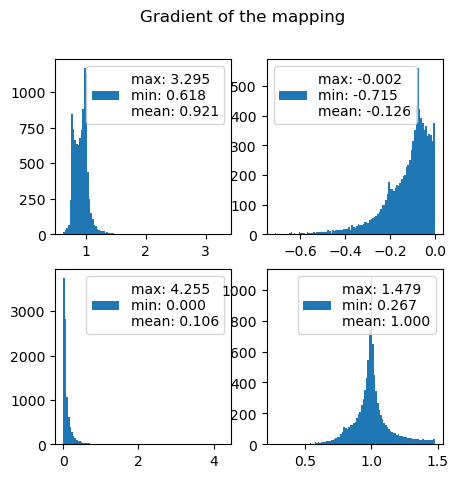

In [ ]:
import matplotlib.pyplot as plt

R=0.5
L=2.0
ngrid=100

x_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
y_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
# X_input_bcs = np.stack((x_bcs, y_bcs), axis=1)
X_input_bcs = [[x_bcs, y_bcs]]
F_bcs = model.predict(X_input_bcs)

x_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
y_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
# X_input = np.stack((x_center, y_center), axis=1)
Xgrid_sol, Ygrid_sol = np.meshgrid(x_center, y_center, indexing="ij")
grad_vmap = jax.vmap(jax.jacfwd(coordMap))(np.stack((Xgrid_sol.ravel(), Ygrid_sol.ravel()), axis=1))

fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for i in range(4):
    ax[i//2, i%2].hist(grad_vmap[:,i//2:i//2+1,i%2], bins=100, label=f"max: {np.max(grad_vmap[:,i//2:i//2+1,i%2]):.3f}\nmin: {np.min(grad_vmap[:,i//2:i//2+1,i%2]):.3f}\nmean: {np.mean(grad_vmap[:,i//2:i//2+1,i%2]):.3f}")
    ax[i//2, i%2].legend()
plt.suptitle("Gradient of the mapping")
plt.show()

# plt.hist(grad_vmap[:,0:1,0], bins=100)

In [ ]:
import matplotlib.colors as colors
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt

R=0.5
L=2.0
ngrid=100

x_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
y_bcs = np.linspace(0,L,ngrid).reshape(-1,1)
# X_input_bcs = np.stack((x_bcs, y_bcs), axis=1)
X_input_bcs = [[x_bcs, y_bcs]]
F_bcs = model.predict(X_input_bcs)

x_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
y_center = np.linspace(0,L,2*ngrid)[1:-1:2].reshape(-1,1)
# X_input = np.stack((x_center, y_center), axis=1)
Xgrid_sol, Ygrid_sol = np.meshgrid(x_center, y_center, indexing="ij")
Xmesh_sol = jax.vmap(coordMap)(np.stack((Xgrid_sol.ravel(), Ygrid_sol.ravel()), axis=1))
Xmesh_sol, Ymesh_sol = Xmesh_sol[:,0].reshape(Xgrid_sol.shape), Xmesh_sol[:,1].reshape(Ygrid_sol.shape)

X_input = [[x_center, y_center]]
x_edge = np.linspace(0,L,ngrid)
y_edge = np.linspace(0,L,ngrid)

Xgrid, Ygrid = np.meshgrid(x_edge, y_edge, indexing="ij")
Xmesh = jax.vmap(coordMap)(np.stack((Xgrid.ravel(), Ygrid.ravel()), axis=1))
Xmesh, Ymesh = Xmesh[:,0].reshape(Xgrid.shape), Xmesh[:,1].reshape(Ygrid.shape)

F = model.predict(X_input)
Ux = F[:, 0:1].reshape(len(x_center), len(y_center))
Uy = F[:, 1].reshape(len(x_center), len(y_center))
Sxx = F[:, 2].reshape(len(x_center), len(y_center))
Syy = F[:, 3].reshape(len(x_center), len(y_center))
Sxy = F[:, 4].reshape(len(x_center), len(y_center))


cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = colors.ListedColormap(color_values)

def pcolor_plot(AX, X, Y, C, title,colormap=cmap,norm=None):

    # X, Y = compute_edges_from_nodes(X, Y)
    im = AX.pcolormesh(X, Y, C, cmap=colormap,shading='auto',norm=norm, edgecolors='none', linewidth=0.01)

    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im

# fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# im = pcolor_plot(axs[0], Xmesh, Ymesh, Ux, "Ux")
# fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(axs[1], Xmesh, Ymesh, Uy, "Uy")
# fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))

# fig, axs = plt.subplots(1, 3, figsize=(24, 6))
# im = pcolor_plot(axs[0], Xmesh, Ymesh, Sxx, "Sxx")
# fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(axs[1], Xmesh, Ymesh, Syy, "Syy")
# fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
# im = pcolor_plot(axs[2], Xmesh, Ymesh, Sxy, "Sxy")
# fig.colorbar(im, ax=axs[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))


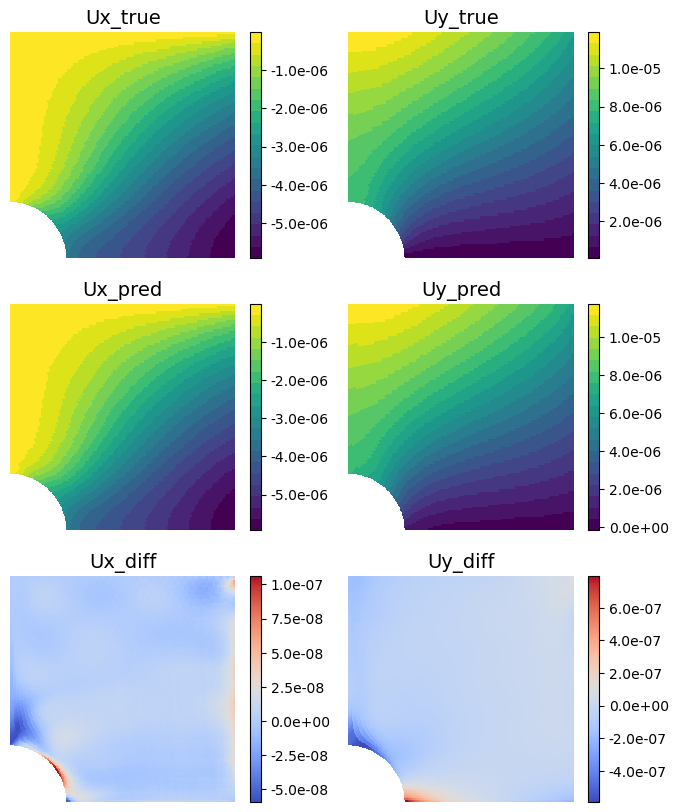

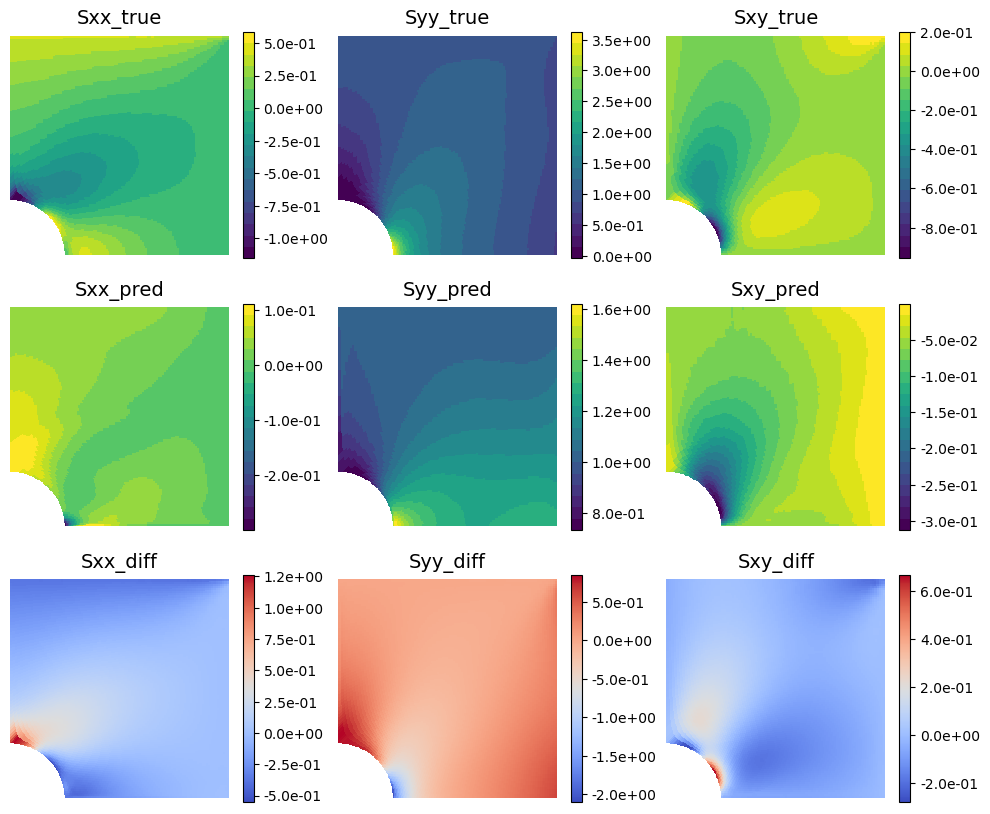

In [60]:
fields_bc_true = [solution_fn(np.hstack((Xgrid.reshape(-1, 1), Ygrid.reshape(-1, 1))))[:, i].reshape(Xgrid.shape) for i in range(5)]
fields_true = [solution_fn(np.hstack((Xgrid_sol.reshape(-1, 1), Ygrid_sol.reshape(-1, 1))))[:, i].reshape(Xgrid_sol.shape) for i in range(5)]

titles = ["Ux", "Uy", "Sxx", "Syy", "Sxy"]
fields = [Ux, Uy, Sxx, Syy, Sxy]
fig, axs = plt.subplots(3, 2, figsize=(8, 10))
for i, ax in enumerate(axs.T):
    im = pcolor_plot(ax[0], Xmesh, Ymesh, fields_true[i], titles[i]+"_true")
    fig.colorbar(im, ax=ax[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    norm = colors.Normalize(vmin=fields_true[i].min(), vmax=fields_true[i].max())
    im = pcolor_plot(ax[1], Xmesh, Ymesh, fields[i], titles[i]+"_pred")#,norm=norm)
    fig.colorbar(im, ax=ax[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    im = pcolor_plot(ax[2], Xmesh, Ymesh, fields[i] - fields_true[i], titles[i]+"_diff",colormap='coolwarm')
    fig.colorbar(im, ax=ax[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))


fig, axs = plt.subplots(3, 3, figsize=(12, 10))
for i, ax in enumerate(axs.T):
    im = pcolor_plot(ax[0], Xmesh, Ymesh, fields_true[i+2], titles[i+2]+"_true")
    fig.colorbar(im, ax=ax[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    norm = colors.Normalize(vmin=fields_true[i+2].min(), vmax=fields_true[i+2].max())
    im = pcolor_plot(ax[1], Xmesh, Ymesh, fields[i+2], titles[i+2]+"_pred")#,norm=norm)
    fig.colorbar(im, ax=ax[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    im = pcolor_plot(ax[2], Xmesh, Ymesh, fields[i+2] - fields_true[i+2], titles[i+2]+"_diff",colormap='coolwarm')
    fig.colorbar(im, ax=ax[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))


/tmp/ipykernel_8594/2469572693.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


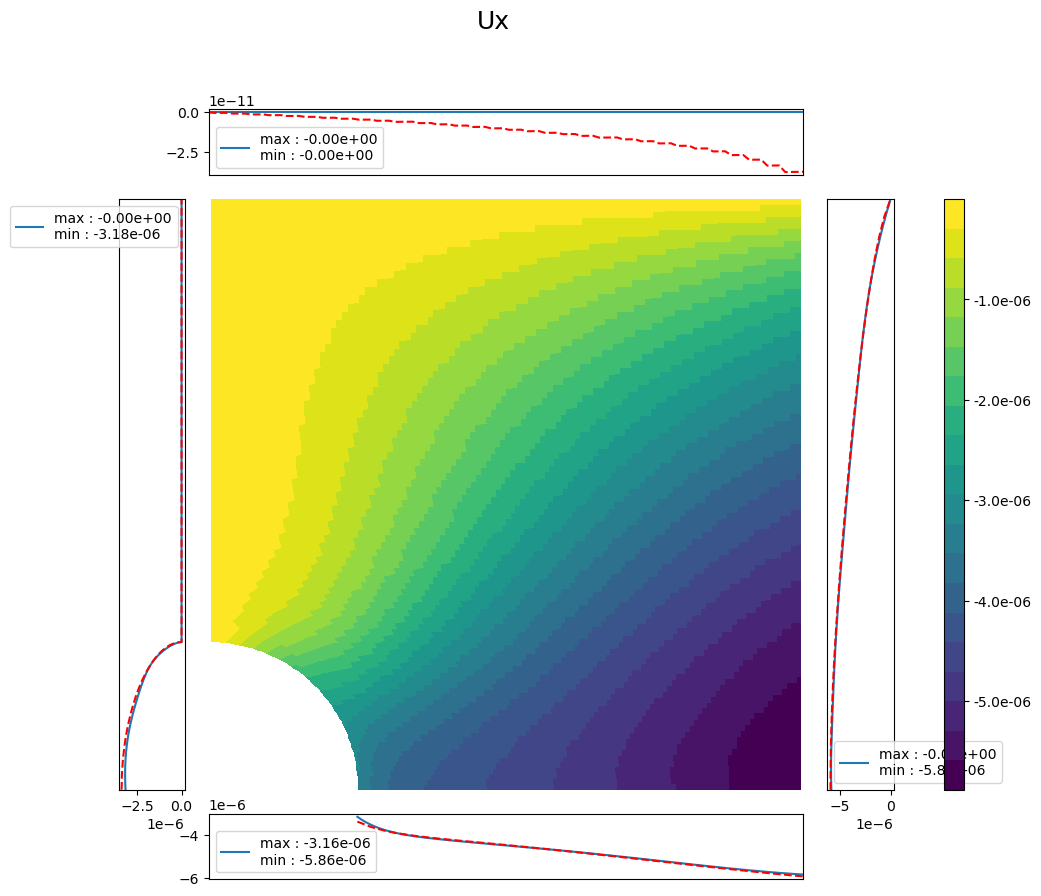

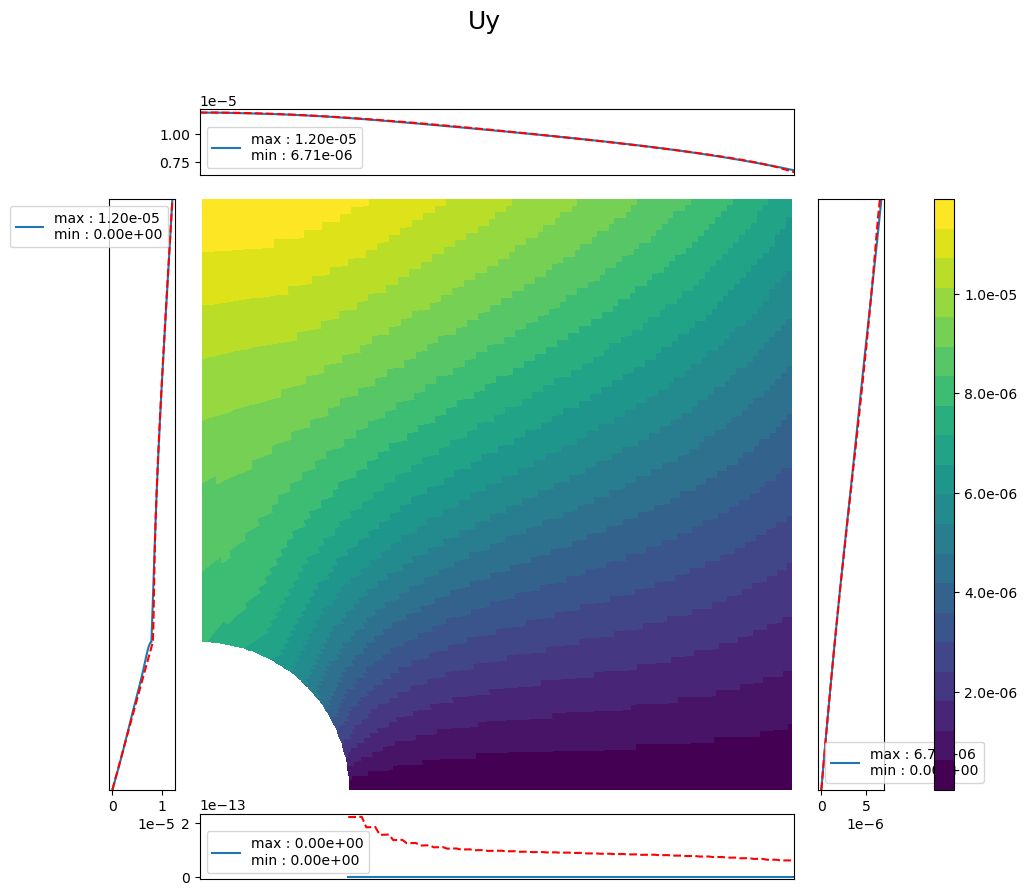

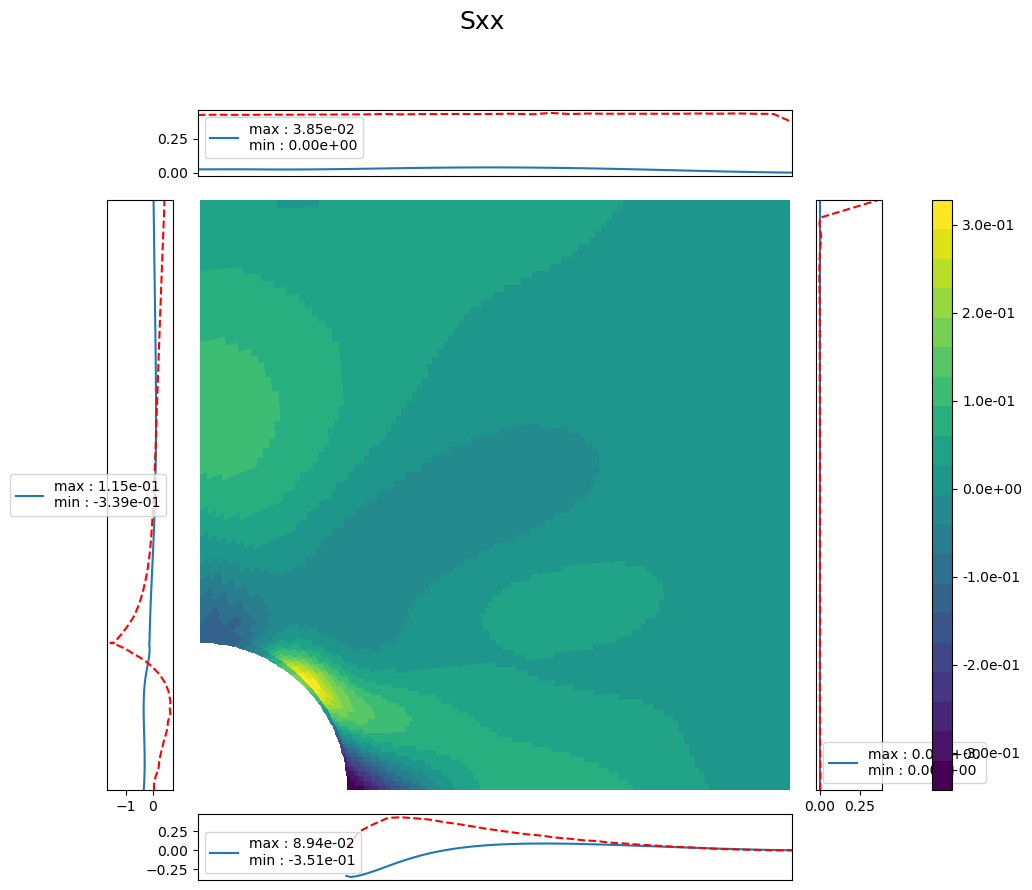

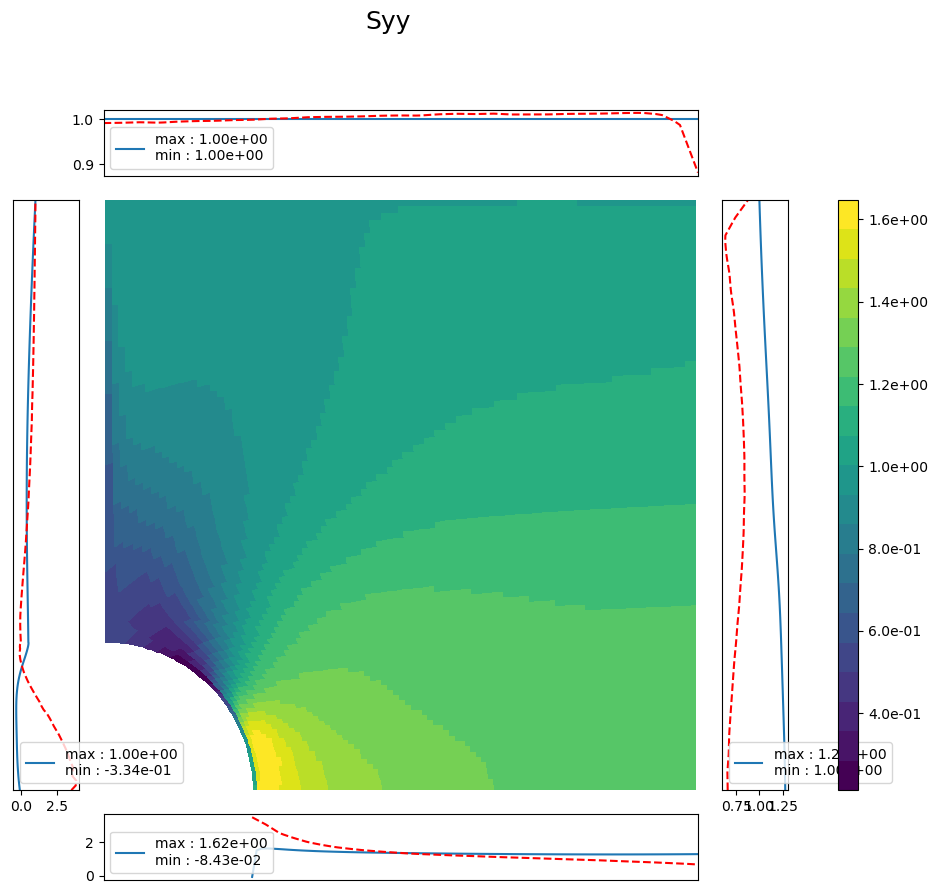

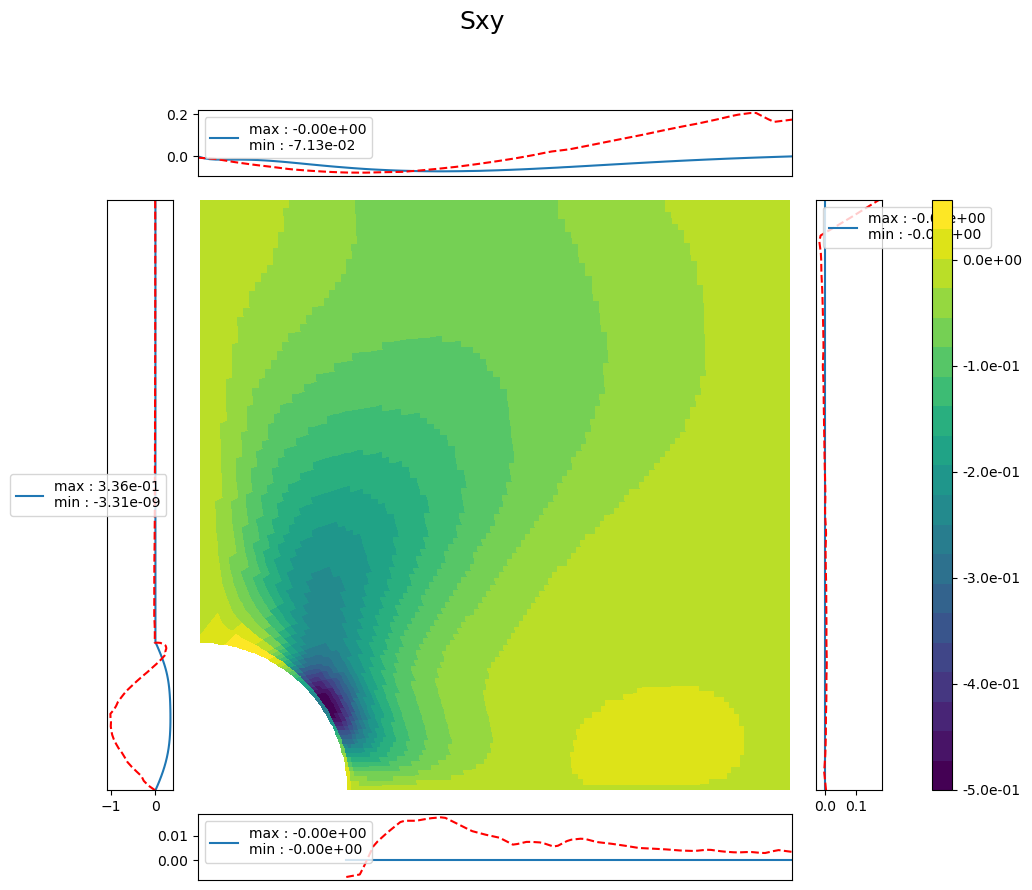

In [53]:

def plot_boundary(F, F_bc, F_true, X, Y, title, axs):
    x_top = X[:,-1]
    x_bottom = X[:,0]
    y_left = Y[0,:]
    y_right = Y[-1,:]

    F_top = F_bc[-1,:]
    F_bottom = F_bc[0,:]
    F_left = F_bc[:,0]
    F_right = F_bc[:,-1]

    x_bcs = [x_top, x_bottom, F_left, F_right] 
    y_bcs = [F_top, F_bottom, y_left, y_right]

    F_top_true = F_true[-1,:]
    F_bottom_true = F_true[0,:]
    F_left_true = F_true[:,0]
    F_right_true = F_true[:,-1]

    x_bcs_true = [x_top, x_bottom, F_left_true, F_right_true]
    y_bcs_true = [F_top_true, F_bottom_true, y_left, y_right]

    index_bcs = [[0,1],[2,1],[1,0],[1,2]]

    axs[0][0].axis("off")
    axs[0][2].axis("off")
    axs[2][0].axis("off")
    axs[2][2].axis("off")

    for i, (x_bc, y_bc, x_bc_true, y_bc_true, ind) in enumerate(zip(x_bcs, y_bcs, x_bcs_true, y_bcs_true, index_bcs)):
        # axs[ind[0]][ind[1]].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
        if i<2:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(y_bc):.2e}\nmin : {np.min(y_bc):.2e}")
            axs[ind[0]][ind[1]].plot(x_bc_true, y_bc_true, color='red', linestyle='--')
            axs[ind[0]][ind[1]].xaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_xlim([0, 2.0])
            # axs[ind[0]][ind[1]].set_ylim([min(y_bc), max(y_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_yscale('log')

        else:
            axs[ind[0]][ind[1]].plot(x_bc, y_bc, label=f"max : {np.max(x_bc):.2e}\nmin : {np.min(x_bc):.2e}")
            axs[ind[0]][ind[1]].plot(x_bc_true, y_bc_true, color='red', linestyle='--')

            axs[ind[0]][ind[1]].yaxis.set_visible(False)
            axs[ind[0]][ind[1]].set_ylim([0, 2.0])
            # axs[ind[0]][ind[1]].set_xlim([min(x_bc), max(x_bc)])
            #log scale
            # axs[ind[0]][ind[1]].set_xscale('log')
        axs[ind[0]][ind[1]].legend()
            
    im = pcolor_plot(axs[1][1], X, Y, F, None)
    axs[1][1].set_zorder(-1)
    pos = axs[1][2].get_position()
    cax = fig.add_axes([pos.width + pos.x0 +0.05, pos.y0, 0.02, pos.height])
    fig.colorbar(im, cax=cax, format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
    plt.tight_layout()
    plt.suptitle(title, fontsize=18)


fields = [Ux, Uy, Sxx, Syy, Sxy]
fields_bc = [F_bcs[:,i].reshape(len(x_bcs), len(y_bcs)).T for i in range(5)]
# fields_bc_true = [solution_fn(np.hstack((Xmesh.reshape(-1, 1), Ymesh.reshape(-1, 1))))[:, i].reshape(Xmesh.shape) for i in range(5)]
titles = ["Ux", "Uy", "Sxx", "Syy", "Sxy"]

for i,title in enumerate(titles):
    field = fields[i]
    field_bc = fields_bc[i]
    field_true = fields_bc_true[i].T
    fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
    plot_boundary(field, field_bc, field_true, Xmesh, Ymesh, title, axs)

# fig, axs = plt.subplots(3, 3, figsize=(10, 10), height_ratios=[0.1, 0.9, 0.1], width_ratios=[0.1, 0.9, 0.1], gridspec_kw={"hspace": 0.1, "wspace": 0.1})
# plot_boundary(Ux, Xmesh, Ymesh, "Ux", axs)



Balance loss: 0.81678563
Balance loss check: 6.048302
Balance loss FEM: 0.47085166


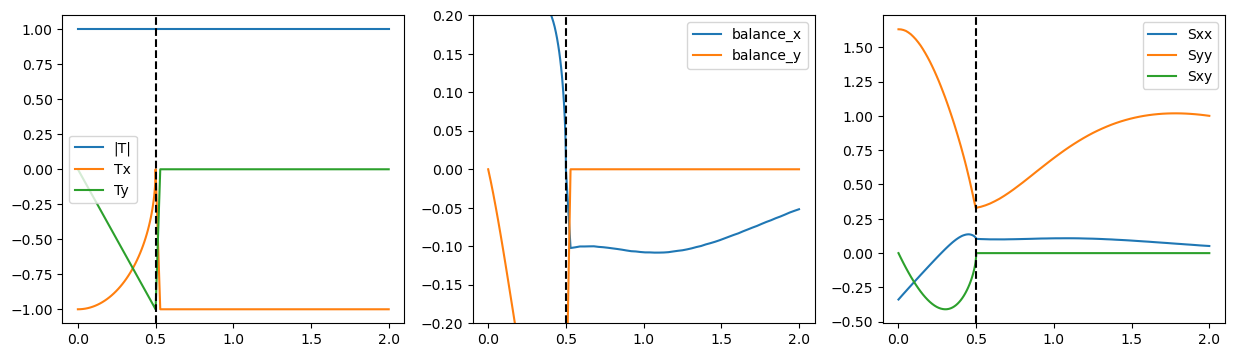

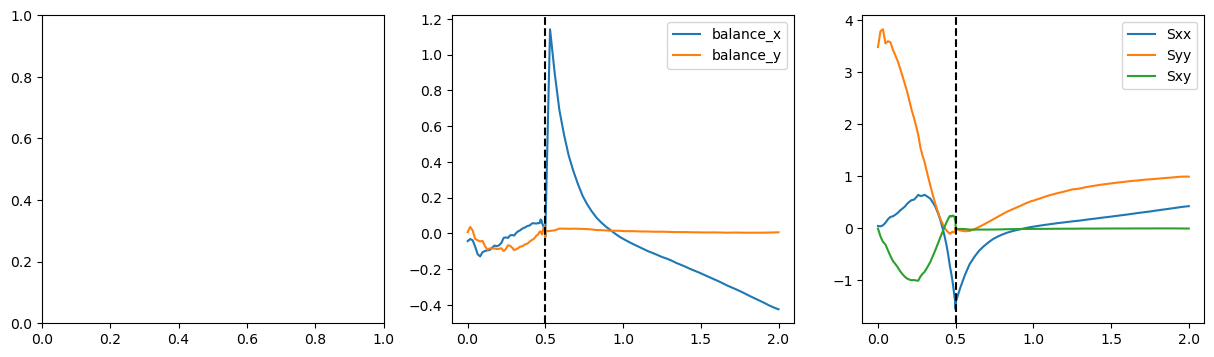

In [46]:
x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)

n_free = 400
y_free = jnp.linspace(0, x_max, n_free)
X_free = jnp.stack((jnp.zeros(n_free), y_free), axis=1)
sharp_corner_tol = 0.1

mask = (jax.vmap(coordMap)(X_free)[:, 1] < R-sharp_corner_tol) & (sharp_corner_tol < jax.vmap(coordMap)(X_free)[:, 1])
X_free = X_free[mask] #keep bottom left corner: 99 points

X_list = [jnp.array([0]).reshape(-1, 1), X_free[:, 1].reshape(-1, 1)]

X_left_mapped = jax.vmap(coordMap)(X_left)

Tx = [-X_left_mapped[i,0]/R if X_left_mapped[i,1] <= R+1e-6 else -1 for i in range(ngrid)]
Ty = [-X_left_mapped[i,1]/R if X_left_mapped[i,1] <= R+1e-6 else 0 for i in range(ngrid)] 

normal_mapped = jax.vmap(calcNormal)(X_left)
Tx_j, Ty_j = normal_mapped[:, 0], normal_mapped[:, 1]
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.quiver(X_left_mapped[:,0], X_left_mapped[:,1], Tx, Ty, scale=7)
# plt.quiver(X_left_mapped[:,0], X_left_mapped[:,1], Tx_j, Ty_j, scale=7, color='r')


# plt.scatter(X_left_mapped[:,0], X_left_mapped[:,1], c=Tx, cmap='viridis', s=1)
# plt.gca().set_aspect('equal', adjustable='box')
# ax.set_xlim([-0.2, 0.55])

Tx, Ty = jnp.array(Tx), jnp.array(Ty)
Sxx_left = fields_bc[2][:,0]
Syy_left = fields_bc[3][:,0]
Sxy_left = fields_bc[4][:,0]
# Sbc_left = fields_bc[5][:,0]

balance_x = Sxx_left*Tx + Sxy_left*Ty 
balance_y = Sxy_left*Tx + Syy_left*Ty

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].plot(X_left_mapped[:,1],np.array(Tx)**2 + np.array(Ty)**2, label='|T|')
axs[0].plot(X_left_mapped[:,1],Tx, label='Tx')
axs[0].plot(X_left_mapped[:,1],Ty, label='Ty')
axs[0].axvline(0.5, color='black', linestyle='--')
axs[0].legend()

axs[1].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y, label='balance_y')
axs[1].axvline(0.5, color='black', linestyle='--')
axs[1].legend()
axs[1].set_ylim([-0.2, 0.2])
# axs[1].set_ylim([-0.05, 0.05])

axs[2].plot(X_left_mapped[:,1],Sxx_left, label='Sxx')
axs[2].plot(X_left_mapped[:,1],Syy_left, label='Syy')
axs[2].plot(X_left_mapped[:,1],Sxy_left, label='Sxy')
axs[2].axvline(0.5, color='black', linestyle='--')
# axs[2].set_ylim([-0.3, 0.3])

# axs[2].plot(X_left_mapped[:,1],Sbc_left, label='Sbc')
axs[2].legend()


inputs = [X_list]
outputs = model.predict(inputs)
print("Balance loss:", np.mean(np.square(free_surface_balance(inputs[0], [outputs], X_left_mapped))))
print("Balance loss check:", np.mean(np.square(np.linalg.norm(balance_x[y_left<0.5]) + np.linalg.norm(balance_y[y_left<0.5]))))


def solution_fn_flat(x):
    return np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

F_left_exact = solution_fn_flat(np.stack((x_left, y_left), axis=1))

balance_x = F_left_exact[:,2]*Tx + F_left_exact[:,4]*Ty
balance_y = F_left_exact[:,4]*Tx + F_left_exact[:,3]*Ty

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[2].plot(X_left_mapped[:,1],F_left_exact[:,2], label='Sxx')
axs[2].plot(X_left_mapped[:,1],F_left_exact[:,3], label='Syy')
axs[2].plot(X_left_mapped[:,1],F_left_exact[:,4], label='Sxy')
axs[2].axvline(0.5, color='black', linestyle='--')
# axs[2].set_ylim([-1, 1])
axs[2].legend()

axs[1].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[1].plot(X_left_mapped[:,1],balance_y, label='balance_y')
axs[1].axvline(0.5, color='black', linestyle='--')
# axs[1].set_ylim([-0.2, 0.2])
axs[1].legend()



print("Balance loss FEM:", np.mean(np.square(np.linalg.norm(balance_x[y_left<0.5]) + np.linalg.norm(balance_y[y_left<0.5]))))



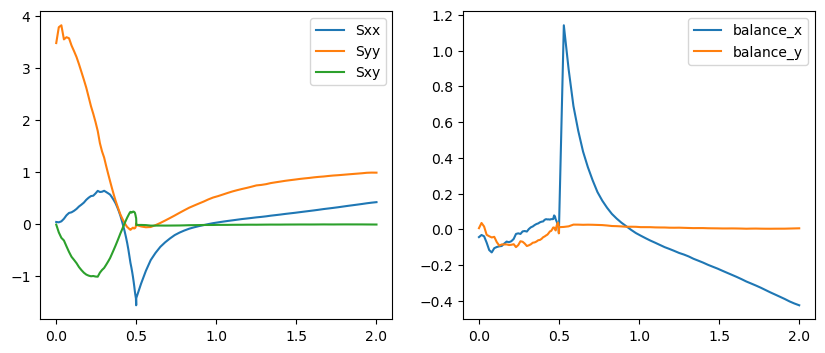

In [ ]:
import numpy as np 
ngrid = 100
x_max = 2.0
def solution_fn_flat(x):
    return np.array([interp((x[:,0], x[:,1])) for interp in interpolators]).T

x_left = np.zeros(ngrid)
y_left = np.linspace(0, x_max, ngrid)
X_left = np.stack((x_left, y_left), axis=1)
X_left_mapped = jax.vmap(coordMap)(X_left)

F_left_exact = solution_fn_flat(np.stack((x_left, y_left), axis=1))

balance_x = F_left_exact[:,2]*Tx + F_left_exact[:,4]*Ty
balance_y = F_left_exact[:,4]*Tx + F_left_exact[:,3]*Ty

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[1].plot(X_left_mapped[:,1],F_left_exact[:,2], label='Sxx')
axs[1].plot(X_left_mapped[:,1],F_left_exact[:,3], label='Syy')
axs[1].plot(X_left_mapped[:,1],F_left_exact[:,4], label='Sxy')
axs[1].axvline(0.5, color='black', linestyle='--')
axs[1].legend()

axs[0].plot(X_left_mapped[:,1],balance_x, label='balance_x')
axs[0].plot(X_left_mapped[:,1],balance_y, label='balance_y')
axs[0].axvline(0.5, color='black', linestyle='--')
axs[0].legend()